In [13]:
import pickle
import MDAnalysis as mda
import matplotlib.pyplot as plt
import math
import numpy as np
import csv
import os

In [14]:
def matrix_addition(array1,array2):

    # If arrays are of different lengths, you can pad the shorter one
    if len(array1) > len(array2):
        array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
    else:
        array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
    
    result = array1 + array2

    return result
# [1,2,3] + [4,5] = [5,7,3]

In [15]:
# Load from a file
with open(r'D:\all_programming\MSD\msd_water_box\fixeddatapart.pkl', 'rb') as file:
    data = pickle.load(file)

In [16]:
print(data.keys())
print(data[0].keys())


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [17]:
graphite_water_psf = r'D:\all_programming\MSD\data_files\unwrapped\graphite_water.psf'
graphite_trajectory_dcd = r'D:\all_programming\MSD\data_files\unwrapped\output_per_20ps.dcd'

global_uni = mda.Universe(graphite_water_psf,graphite_trajectory_dcd)
Oxg_uni = global_uni.select_atoms('resname SPCE and name OW')
# Importing data

In [29]:
z_maxs = []

for frame in range(len(global_uni.trajectory)):
    global_uni.trajectory[frame]
    z_vals = []
    for atom in Oxg_uni.positions:
        z_vals.append(atom[2])
    z_maxs.append(max(z_vals))
# Appends the max z_val in each frame to z_maxs

average_z_max = sum(z_maxs)/len(z_maxs)
partition_count = 4
z_partitions = []

for i in range(int(global_uni.dimensions[2] / 10)):
    z_ceiling = i * 10
    if average_z_max < z_ceiling:
        for i in range(partition_count):
            z_partitions.append(z_ceiling / partition_count * (i + 1))
        break
# Creating a slightly generalized partition, essentially just making sure our partition ends further up then out average_z_max

66.09634166272545


In [19]:
partition_msd = {}
for i in range(len(z_partitions)):
    partition_msd[i] = []
# Creating following structure -> {0:[],1:[],...n:[]} (0,1,2,3)

for atom in data.keys():
    for i in range(len(z_partitions)):
        partition_msd[i] = partition_msd[i] + data[atom][i]

# Appending each elements list to partition_msd
#                                          v Arrays are from all different atoms
# Partition_msd follows the structure {0:[arr1,arr2,...],...}

In [20]:
part_lengths = {}

for partition in partition_msd:
    part_lengths[partition] = []

    for item in partition_msd[partition]:
        part_lengths[partition].append(len(item))
# Creating a dictionary of the structure {0:[len(arr1),len(arr2),...],...}
# len(part_lengths[0]) == total amount of msd arrays, ie how much shifting occured in a certain partition
# part_lengths.keys() is just the amount of partitions we got

In [21]:
average_dict = {}

for key in part_lengths.keys():

    updated = sorted(part_lengths[key])
    average_dict[key] = {}

    while True:
        try:
            #print(len(updated), updated) | len(updated) -> total amount of arrays, updated -> array of lengths of arrays | updated[-1] -> length of longest array
            lowest_len = min(updated)
            average_dict[key][lowest_len] = len(updated)
            updated = [element for element in updated if element != lowest_len]

        except ValueError:
            break

# len(average_dict[0]) == len(partition_msd[0] - arrays of duplicate length)
# Thus 184 arrays of unique length exist in partition_msd[0]
# There exist 73903 arrays with at least 1 element | 52058 arrays with at least 2 elements | 42415 arrays with at least 3 elements | etc | 14 arrays with at least 187 elements | 1 arr with at least 233 elements 
# Divide 233 element by 1, 232e by 1, ..., 229e by 2, 228 by 2, ...

In [22]:
longest_ar_dict = {}

for key in average_dict:
    longest_array = max(average_dict[key].keys())
    longest_ar_dict[key] = longest_array

# Dictionary with structure {partition:longest arr in part,...}

In [23]:
averaged_msd = {}

for key in partition_msd:
    averaged_msd[key] = np.zeros(longest_ar_dict[key])
# Turns {} -> {0:[...],...} with keys = 0,1,2,3 and len(dict[0]) being made up of all 0's and with the same length as the longest msd_array in msd_partition
# longest_ar_dict[0] = 233

for key in average_dict:
    for matrix in partition_msd[key]:
        averaged_msd[key] = matrix_addition(averaged_msd[key], matrix) 
    # Loops through each msd_arr and adds each of its elements to our current avg_msd arr for some partition


In [24]:
division_to_key = {}

for part in range(len(z_partitions)):
    division_to_key[part] = {}
    for i in range(len(average_dict[part].keys())):
        try:
            carkeys = average_dict[part].keys()
            first_key = list(carkeys)[-(i + 1)]
            prior_key = list(carkeys)[-(i + 2)]
            first_value = average_dict[part][first_key]
            delta = first_key - prior_key

            for j in range(delta):
                division_to_key[part][first_key - j] = first_value

        except IndexError:
            division_to_key[part][1] = average_dict[part][1]
            #print('Completed process.')

def reverse_secondary_indexes(sub_dict):
    return {key: sub_dict[key] for key in sorted(sub_dict)}

# Create a new dictionary with reversed secondary indexes
division_to_key = {key: reverse_secondary_indexes(division_to_key[key]) for key in division_to_key}


In [25]:
final_msd = {}

for part in range(len(z_partitions)):
    final_msd[part] = {}
    for key in division_to_key[part]:

        final_msd[part][key] = averaged_msd[part][key - 1] / division_to_key[part][key]
        #                       ^Start at 0 goes to 232           ^Start at 1 go to 233

In [26]:
final_final_msd = {}
final_list_vals = {}

for part in final_msd.keys():
    final_final_msd[part] = []
    final_list_vals[part] = []

    for key in final_msd[part].keys():
        final_list_vals[part].append(key)
        final_final_msd[part].append(final_msd[part][key])

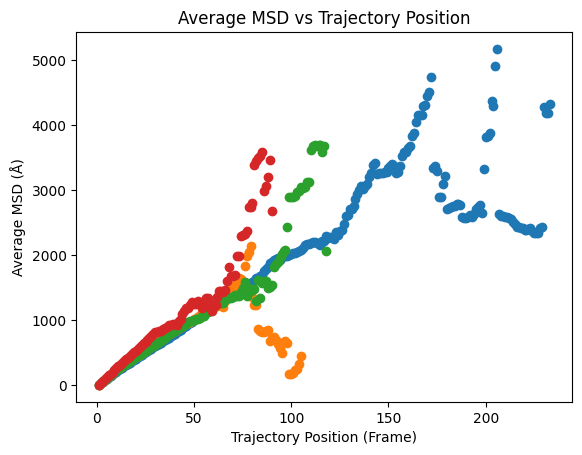

In [27]:
for i in range(len(z_partitions)):
    x_vals = final_list_vals[i]
    y_vals = final_final_msd[i]

    plt.scatter(x_vals, y_vals)
    plt.xlabel('Trajectory Position (Frame)')
    plt.ylabel('Average MSD (Å)')
    plt.title('Average MSD vs Trajectory Position')
    plt.plot()

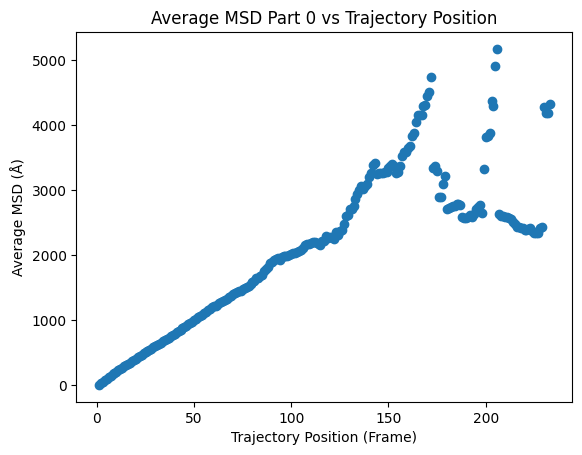

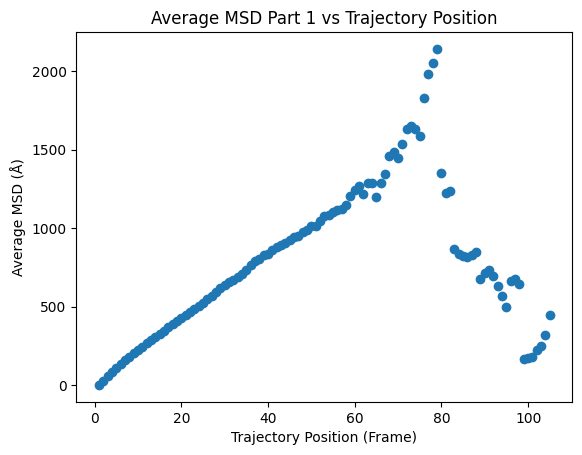

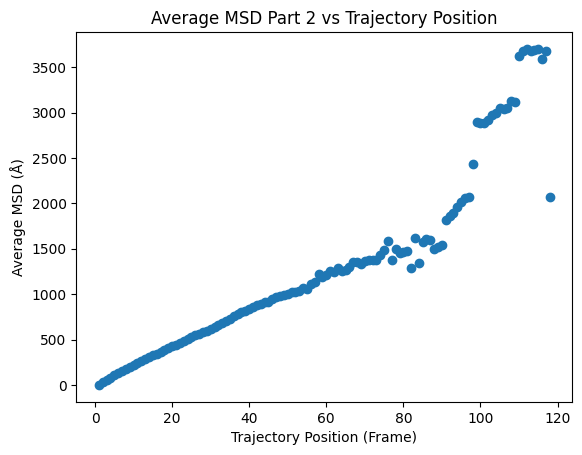

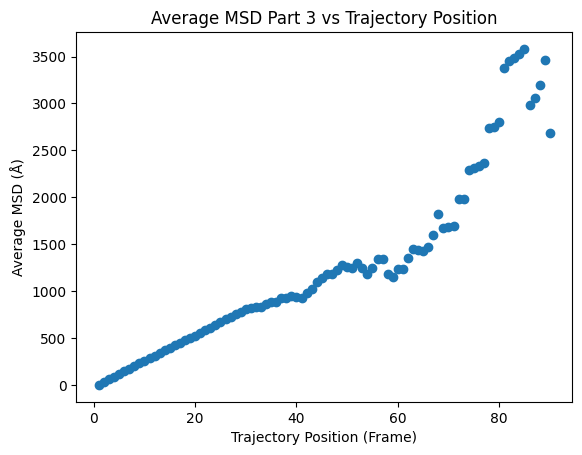

In [28]:
for i in range(len(z_partitions)):
    x_vals = final_list_vals[i]
    y_vals = final_final_msd[i]

    plt.figure()
    plt.scatter(x_vals, y_vals)
    plt.xlabel('Trajectory Position (Frame)')
    plt.ylabel('Average MSD (Å)')
    plt.title(f'Average MSD Part {i} vs Trajectory Position')
    plt.plot()

    #save_dir = r'D:\all_programming\MSD\msd_water_box\data_output\8_part_default'
    #file_path = os.path.join(save_dir, f'MSD_part{i}.png')
    #plt.savefig(file_path)